## VAE MNIST example: BO in a latent space

In this tutorial, we use the MNIST dataset and some standard PyTorch examples to show a synthetic problem where the input to the objective function is a `28 x 28` image. The main idea is to train a [variational auto-encoder (VAE)](https://arxiv.org/abs/1312.6114) on the MNIST dataset and run Bayesian Optimization in the latent space. We also refer readers to [this tutorial](http://krasserm.github.io/2018/04/07/latent-space-optimization/), which discusses [the method](https://arxiv.org/abs/1610.02415) of jointly training a VAE with a predictor (e.g., classifier), and shows a similar tutorial for the MNIST setting.

In [1]:
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets  # transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
SMOKE_TEST = os.environ.get("SMOKE_TEST", False)

In [2]:
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms import Standardize, Normalize

from botorch.optim import optimize_acqf


from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

c:\Users\82109\anaconda3\envs\botorch_ex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem setup

Let's first define our synthetic expensive-to-evaluate objective function. We assume that it takes the following form:

$$\text{image} \longrightarrow \text{image classifier} \longrightarrow \text{scoring function} 
\longrightarrow \text{score}.$$

The classifier is a convolutional neural network (CNN) trained using the architecture of the [PyTorch CNN example](https://github.com/pytorch/examples/tree/master/mnist).

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
def get_pretrained_dir() -> str:
    """
    Get the directory of pretrained models, which are in the BoTorch repo.

    Returns the location specified by PRETRAINED_LOCATION if that env
    var is set; otherwise checks if we are in a likely part of the BoTorch
    repo (botorch/botorch or botorch/tutorials) and returns the right path.
    """
    if "PRETRAINED_LOCATION" in os.environ.keys():
        return os.environ["PRETRAINED_LOCATION"]
    cwd = os.getcwd()
    folder = os.path.basename(cwd)
    # automated tests run from botorch folder
    if folder == "botorch":  
        return os.path.join(cwd, "tutorials/pretrained_models/")
    # typical case (running from tutorial folder)
    elif folder == "tutorials":
        return os.path.join(cwd, "pretrained_models/")
    raise FileNotFoundError("Could not figure out location of pretrained models.")


In [14]:
cnn_weights_path = os.path.join(get_pretrained_dir(), "mnist_cnn.pt")
cnn_model = Net().to(dtype=dtype, device=device)
cnn_state_dict = torch.load(cnn_weights_path, map_location=device)
cnn_model.load_state_dict(cnn_state_dict);

Our VAE model follows the [PyTorch VAE example](https://github.com/pytorch/examples/tree/master/vae), except that we use the same data transform from the CNN tutorial for consistency. We then instantiate the model and again load a pre-trained model. To train these models, we refer readers to the PyTorch Github repository. 

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

vae_weights_path = os.path.join(get_pretrained_dir(), "mnist_vae.pt")
vae_model = VAE().to(dtype=dtype, device=device)
vae_state_dict = torch.load(vae_weights_path, map_location=device)
vae_model.load_state_dict(vae_state_dict);

We now define the scoring function that maps digits to scores. The function below prefers the digit '3'.

In [7]:
def score(y):
    """Returns a 'score' for each digit from 0 to 9. It is modeled as a squared exponential
    centered at the digit '3'.
    """
    return torch.exp(-2 * (y - 3) ** 2)

Given the scoring function, we can now write our overall objective, which as discussed above, starts with an image and outputs a score. Let's say the objective computes the expected score given the probabilities from the classifier.

In [8]:
def score_image(x):
    """The input x is an image and an expected score 
    based on the CNN classifier and the scoring 
    function is returned.
    """
    with torch.no_grad():
        probs = torch.exp(cnn_model(x))  # b x 10
        scores = score(
            torch.arange(10, device=device, dtype=dtype)
        ).expand(probs.shape)
    return (probs * scores).sum(dim=1)

Finally, we define a helper function `decode` that takes as input the parameters `mu` and `logvar` of the variational distribution and performs reparameterization and the decoding. We use batched Bayesian optimization to search over the parameters `mu` and `logvar`

In [9]:
def decode(train_x):
    with torch.no_grad():
        decoded = vae_model.decode(train_x)
    return decoded.view(train_x.shape[0], 1, 28, 28)

#### Model initialization and initial random batch

We use a `SingleTaskGP` to model the score of an image generated by a latent representation. The model is initialized with points drawn from $[-6, 6]^{20}$.

In [10]:
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.transforms import Standardize, Normalize
from botorch import fit_gpytorch_mll

d = 20
bounds = torch.tensor([[-6.0] * d, [6.0] * d], device=device, dtype=dtype)


def gen_initial_data(n=10):
    # generate training data
    train_x = unnormalize(
        torch.rand(n, d, device=device, dtype=dtype), 
        bounds=bounds
    )
    train_obj = score_image(decode(train_x)).unsqueeze(-1)
    best_observed_value = train_obj.max().item()
    return train_x, train_obj, best_observed_value

In [ ]:
# def get_fitted_model(model, train_x, train_obj, num_context, num_target, state_dict=None):
#     # fit model
#     np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
#                                   num_context_range=(num_context, num_context),
#                                   num_extra_target_range=(num_target, num_target), 
#                                   print_freq=200)
#     sampler = StochasticSampler(torch.Size([BATCH_SIZE]), seed=1234)
#     obj = IdentityMCObjective()

#     # model = SingleTaskGP(
#     #     train_X=normalize(train_x, bounds), 
#     #     train_Y=train_obj,
#     #     outcome_transform=Standardize(m=1)
#     # )
#     # if state_dict is not None:
#     #     model.load_state_dict(state_dict)
#     # mll = ExactMarginalLogLikelihood(model.likelihood, model)
#     # mll.to(train_x)
#     # fit_gpytorch_mll(mll)
#     return model

#### Define a helper function that performs the essential BO step
The helper function below takes an acquisition function as an argument, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values. For this example, we'll use a small batch of $q=3$.

In [11]:
from botorch.optim import optimize_acqf


BATCH_SIZE = 3 if not SMOKE_TEST else 2
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 256 if not SMOKE_TEST else 4


def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a
    new candidate and a noisy observation"""

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.stack(
            [
                torch.zeros(d, dtype=dtype, device=device),
                torch.ones(d, dtype=dtype, device=device),
            ]
        ),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )

    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=bounds)
    new_obj = score_image(decode(new_x)).unsqueeze(-1)
    return new_x, new_obj

### Perform Bayesian Optimization loop with qEI
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps: (1) given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$, (2) observe $f(x)$ for each $x$ in the batch, and (3) update the surrogate model. We run `N_BATCH=75` iterations. The acquisition function is approximated using `MC_SAMPLES=2048` samples. We also initialize the model with 5 randomly drawn points.

In [49]:
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

seed = 1
torch.manual_seed(seed)

N_BATCH = 25 if not SMOKE_TEST else 3
best_observed = []

# call helper function to initialize model
train_x, train_obj, best_value = gen_initial_data(n=10)
best_observed.append(best_value)

In [40]:
print(train_x.shape)
print(train_obj.shape)
print(best_observed)

torch.Size([10, 20])
torch.Size([10, 1])
[0.6942477822303772]


We are now ready to run the BO loop (this make take a few minutes, depending on your machine).

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from neural_process import NeuralProcess
from training import NeuralProcessTrainer
from botorch.sampling.normal import SobolQMCNormalSampler
from utils import context_target_split
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.acquisition.objective import IdentityMCObjective

In [41]:
class My_mnist(Dataset):
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y

        # Generate data
        self.data = []
        self.data.append((self.train_x, self.train_y))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [42]:
train_batch_size = 1
mnist_dataset = My_mnist(train_x = train_x, train_y = train_obj)
data_loader = DataLoader(mnist_dataset, batch_size=train_batch_size, shuffle=True)

for _, i in enumerate(data_loader):
    print(i[0].shape)
    print(i[1].shape)

torch.Size([1, 10, 20])
torch.Size([1, 10, 1])


In [70]:
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

## NP model
x_dim = 20
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder
neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)

train_batch_size = 1
num_context = 4
num_target = 4
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

sampler = StochasticSampler(torch.Size([BATCH_SIZE]), seed=1234)
obj = IdentityMCObjective()
##

seed = 1
torch.manual_seed(seed)

N_BATCH = 25 if not SMOKE_TEST else 3
best_observed = []

# call helper function to initialize model
train_x, train_obj, best_value = gen_initial_data(n=10)
best_observed.append(best_value)

print(f"\nRunning BO ", end="\n")

state_dict = None
# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(N_BATCH):

    train_x_normalized = normalize(train_x, bounds)
    best_f = train_obj.max() 
    train_Y = (train_obj - train_obj.mean()) / train_obj.std()

    mnist_dataset = My_mnist(train_x = train_x_normalized, train_y = train_obj)
    data_loader = DataLoader(mnist_dataset, batch_size=train_batch_size, shuffle=True)

    if state_dict is not None:
        neuralprocess.load_state_dict(state_dict)
    neuralprocess.training = True
    np_trainer.train(data_loader, 200)

    # Create a batch
    neuralprocess.training = False
    for batch in data_loader:
        break
    x, y = batch
    x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                    num_context, 
                                                    num_target)
    neuralprocess.set_context_for_posterior(x_context, y_context)

    # define the qNEI acquisition function
    qEI = qExpectedImprovement(neuralprocess, best_f, sampler, obj)
    # qEI = qExpectedImprovement(
    #     model=neuralprocess, best_f=train_obj.max()
    # )

    # optimize and get new observation
    new_x, new_obj = optimize_acqf_and_get_observation(qEI)

    # update training points
    train_x = torch.cat((train_x, new_x))
    train_obj = torch.cat((train_obj, new_obj))

    # update progress
    best_value = train_obj.max().item()
    best_observed.append(best_value)

    state_dict = neuralprocess.state_dict()

    # print("-"*80, end="")


Running BO 
iteration 200, loss -4.248
iteration 400, loss -5.849
iteration 600, loss -6.632
iteration 800, loss -5.773
iteration 1000, loss -5.147
iteration 1200, loss -6.327
iteration 1400, loss -6.326
iteration 1600, loss -4.900
iteration 1800, loss -5.970
iteration 2000, loss -6.430
iteration 2200, loss -7.622
iteration 2400, loss -9.483
iteration 2600, loss -6.636
iteration 2800, loss -9.242
iteration 3000, loss -8.699
iteration 3200, loss -10.328
iteration 3400, loss -7.741
iteration 3600, loss -9.191
iteration 3800, loss -9.445
iteration 4000, loss -10.250
iteration 4200, loss -4.885
iteration 4400, loss -8.167
iteration 4600, loss -8.682
iteration 4800, loss -9.930
iteration 5000, loss -9.953


Z,R,H_dim = 50 일 때는 loss=-10.8 이정도가 최고 성능인듯?

EI recommends the best point observed so far. We can visualize what the images corresponding to recommended points *would have* been if the BO process ended at various times. Here, we show the progress of the algorithm by examining the images at 0%, 10%, 25%, 50%, 75%, and 100% completion. The first image is the best image found through the initial random batch.

In [62]:
print(train_x.shape)
print(train_x[0])
print(train_x[-1])

torch.Size([85, 20])
tensor([ 3.0916, -2.6483, -1.1632,  2.8162, -5.6486,  3.5983, -1.2344,  3.0525,
         0.8341, -0.7347,  1.6642,  0.2960,  2.1914, -2.3382, -0.4375, -0.5402,
         0.8697, -0.0240,  5.2450,  1.8671])
tensor([ 4.3291, -3.7688,  6.0000,  3.8109, -5.3884,  5.1917,  1.1984,  3.6050,
        -0.1298, -3.5627, -3.7628, -2.6237,  6.0000,  6.0000,  1.2798,  6.0000,
         5.3079,  4.9976, -1.2984, -2.5588])


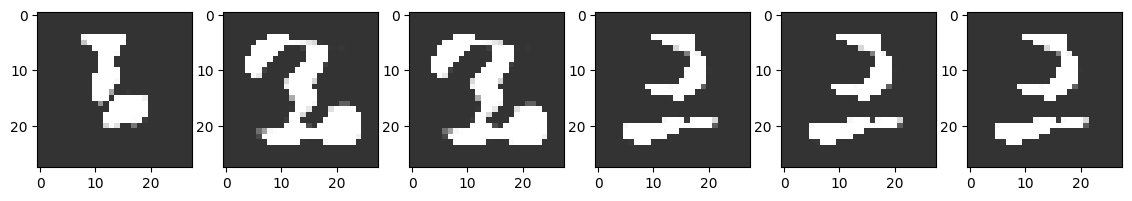

In [71]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline


fig, ax = plt.subplots(1, 6, figsize=(14, 14))
percentages = np.array([0, 10, 25, 50, 75, 100], dtype=np.float32)
inds = (N_BATCH * BATCH_SIZE * percentages / 100 + 4).astype(int)

for i, ax in enumerate(ax.flat):
    b = torch.argmax(score_image(decode(train_x[: inds[i], :])), dim=0)
    img = decode(train_x[b].view(1, -1)).squeeze().cpu()
    ax.imshow(img, alpha=0.8, cmap="gray")